# CS 363M Machine Learning Project

## Authors
- Hudson Gould (HAG929)
- Cristian Cantu (cjc5844)
- Diego Costa (dc48222)
- Dylan Dang (dad4364)

## Background



In this project, we want to predict wether or not a given baseball pitch will be a home run or not. This is an interesting problem because it could be used to better predict the outcomes of baseball games in advance (at least in terms of number of homeruns). Alternatively, one can calculate the probability of a given pitch being a home run *during* the pitch itself (though the outcome will be evident seconds after).

To do this, we are using data from the UT Baseball 2024 Season. Our dataset contains data from every single pitch during UT home games, taken from a TrackMan brand detection machine which tracks and records 3D characteristic of a baseball in motion.

We want to use this data to predict whether a given pitch will be a home run or not. We will use information such as the pitch velocities, runs scored, and other pitch information to predict this. This ML problem is especially interesting, as it suffers from a massive imbalance of classes - far more of the pitches are NOT homeruns, compared to those that are. (Reminiscent of the "predicting credit card fraud" problem). This means that our data will have to be carefully pruned and our modeling techniques must be jucicious to avoid a too-high false negative rate.



## Data Preparation

### Import packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
%matplotlib inline

### Data Cleaning

##### Print the head of the data as a cursory look

In [3]:
data = pd.read_csv('data.csv')

#Print the head of the data
print(data.head())

print(data.shape)

                          game_id        Date     Time  PitchNo  Inning  \
0  20240220-HighPointUniversity-1  2024-02-20  60314.0       82       3   
1  20240220-HighPointUniversity-1  2024-02-20  63576.0      185       6   
2  20240220-HighPointUniversity-1  2024-02-20  66446.0      269       8   
3  20240220-HighPointUniversity-1  2024-02-20  64809.0      216       6   
4  20240220-HighPointUniversity-1  2024-02-20  67985.0      308       9   

  inning_half  PAofInning  PitchofPA           Pitcher   PitcherId  ...    z0  \
0         Top           4          2  Olsovsky, Dalton  1000251274  ...  5.41   
1         Top           2          3     Glover, Lucas  1000138461  ...  6.01   
2         Top           3          1      Carter, Noah  1000108939  ...  5.52   
3      Bottom           6          1     Welch, Collin  1000192105  ...  6.23   
4      Bottom           4          3       Lewis, Zach  1000127413  ...  5.18   

    vx0     vy0    vz0    ax0    ay0    az0          catcher  

One notable feature of this data is the enourmous amount of rows - 1.5 Million! Looking at the first column "game_id", we in fact see that multiple other schools are represented in this dataset, since we see names of schools that are not Texas or it's opponent on a given day (for example, the head of this data shows a game from High Point University v Not Texas). 

For this reason, an easy first step is to remove all the rows not containing "Texas" in the first column, to give us a pruned dataset of ONLY Texas home games. We choose to ignore the Away games, as garnering insights to get a better home field advantage is better than trying to analyze our performance at 6 different other school's fields.

In [16]:
texas_data = data[data['game_id'].str.contains("Texas", na=False)]

texas_data.to_csv("texas_data.csv", index=False)

print(texas_data.head())

print(texas_data.shape)

               game_id        Date     Time  PitchNo  Inning inning_half  \
4651  20240220-Texas-1  2024-02-20  78782.0      357       9         Top   
4652  20240220-Texas-1  2024-02-20  72532.0      158       5         Top   
4657  20240220-Texas-1  2024-02-20  75215.0      239       6      Bottom   
4661  20240220-Texas-1  2024-02-20  77837.0      325       8      Bottom   
4666  20240220-Texas-1  2024-02-20  70275.0      101       3      Bottom   

      PAofInning  PitchofPA           Pitcher   PitcherId  ...   vx0     vy0  \
4651           3          3      O'Hara, Cade  1000192590  ...  1.96 -128.39   
4652           1          2  Hamilton, Hudson      815123  ...  7.30 -133.46   
4657           4          3   Gilley, Brayden  1000165200  ...  2.47 -113.60   
4661           1          3        Ryan, Zach  1000190865  ...  4.08 -120.45   
4666           1          1        Dagley, Ty    10108954  ... -5.73 -116.85   

       vz0   ax0    ay0    az0             catcher catcher_id 

After reducing our dataset to only the Texas home games, our dataset has a much more manageable 10230 rows. This is the dataset we will be basing the rest of our analysis on.

This is good enough for preliminary data cleaning. Now we explore the data to better understand our features and what we need to consider when modeling!

### Data Exploration

In [17]:
cols = texas_data.select_dtypes(include=['object', 'category']).columns
cols = cols.drop(['game_id', 'Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'catcher', 'catcher_team'])

max_col_width = max(len(col) for col in cols)

for col in cols:
    print(f'{col:<{max_col_width}}: {texas_data[col].unique()}')

Date           : ['2024-02-20' '2024-02-23' '2024-02-24' '2024-02-25' '2024-02-16'
 '2024-02-17' '2024-02-18' '2024-03-05' '2024-03-12' '2024-03-15'
 '2024-03-16' '2024-03-17' '2024-03-19' '2024-03-20' '2024-03-22'
 '2024-03-23' '2024-03-24' '2024-03-26' '2024-04-10' '2024-04-16'
 '2024-04-19' '2024-04-20' '2024-04-21' '2024-04-23' '2024-04-30'
 '2024-04-02' '2024-04-04' '2024-04-05' '2024-04-06' '2024-05-18'
 '2024-05-03' '2024-05-04' '2024-05-05']
inning_half    : ['Top' 'Bottom']
PitcherThrows  : ['R' 'L']
BatterSide     : ['L' 'R']
PitchCall      : ['InPlay']
PlayResult     : ['Out' 'Double' 'Single' 'HomeRun' 'Triple']
KorBB          : ['Undefined']
TaggedPitchType: ['Fastball' 'Curveball' 'Slider' 'ChangeUp' 'Cutter' 'Sinker' nan
 'Splitter']
TaggedHitType  : ['fly_ball' nan 'line_drive' 'ground_ball' 'pop_up']


In [21]:
# print number of missing values in each column
missing = texas_data.isnull().sum()
print(missing[missing > 0])

TaggedPitchType                2
RelSpeed                       2
SpinRate                       2
SpinAxis                       2
Tilt                           2
InducedVertBreak               2
VertBreak                      2
HorzBreak                      2
VertApprAngle                  2
HorzApprAngle                  2
vert_rel_angle                 2
horz_rel_angle                 2
RelHeight                      2
RelSide                        2
Extension                      3
PlateLocHeight                 2
PlateLocSide                   2
zone_time                      2
EffectiveVelo                  2
SpeedDrop                      2
TaggedHitType                194
hit_x                        344
hit_y                        344
ExitSpeed                    194
Angle                        194
HitSpinRate                  510
hit_spin_axis                349
Distance                     344
hit_last_tracked_distance    194
hit_hang_time                344
Direction 

In [25]:
print(texas_data['PlayResult'].value_counts())

PlayResult
Out        998
Single     368
Double     120
HomeRun     77
Triple       7
Name: count, dtype: int64


In [26]:
relevant_play_results = ['Single', 'Double', 'Triple', 'HomeRun', 'Out']

# Filter the dataset to keep only relevant play results
texas_data = texas_data[texas_data['PlayResult'].isin(relevant_play_results)]
print(texas_data.shape)

(1570, 78)


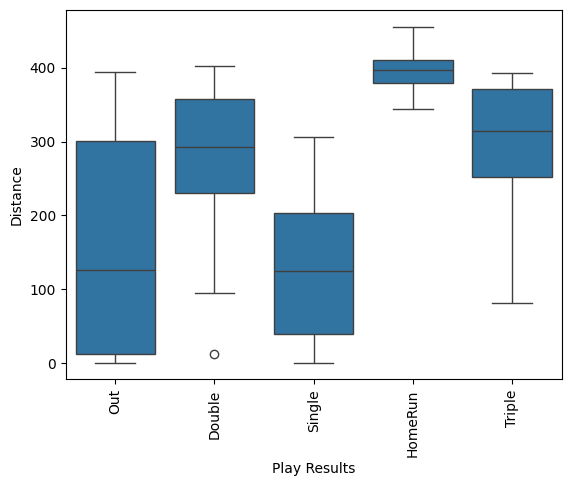

In [27]:
plt.figure()
sns.boxplot(x='PlayResult', y='Distance', data=texas_data)
plt.xlabel('Play Results')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

         Distance
4685          NaN
4723       397.48
4730       383.62
4835       414.62
73795      383.79
73809      394.93
103546     381.69
103667     424.88
103699     374.78
103756     348.36
150040     372.70
176781     362.52
176919     360.45
222099     382.65
222203        NaN
340790     412.61
340971     402.74
420835     418.99
420851     394.22
420974     405.59
450061     353.82
474906     403.88
484969     388.17
484973        NaN
485019     420.05
485132     391.70
536817     394.44
536894     356.89
536904     343.57
536908     404.28
564723     375.57
564844     450.33
564893     367.08
564902     416.71
586802     381.48
819891     358.95
820006     367.97
930891     399.02
930897     412.17
931041     391.63
931073        NaN
957192     369.12
1038904    396.39
1038984    401.65
1039000    385.89
1039001    440.12
1039003    407.11
1039120    406.40
1150720    415.05
1150804    374.91
1150848    407.43
1150882    439.39
1150912    399.46
1171512    363.56
1171560   

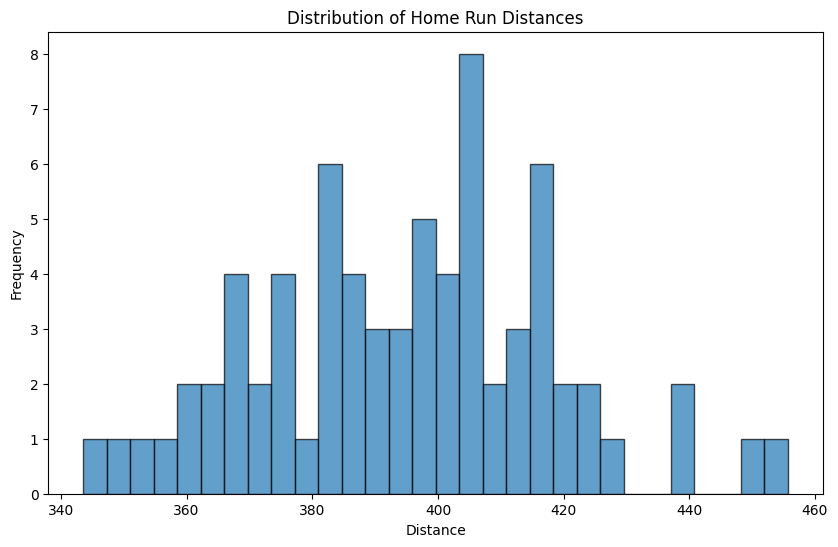

In [28]:
# homerun distances plotted
home_runs = texas_data[texas_data['PlayResult'] == 'HomeRun']
home_run_distances = home_runs[['Distance']]
print(home_run_distances)

home_run_distances.head()

plt.figure(figsize=(10, 6))
plt.hist(home_run_distances['Distance'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Home Run Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Filter home runs less than a distance of 300
data = data[~((data['PlayResult'] == 'HomeRun') & (data['Distance'] < 300))]

In [29]:
# Ensure IsHomeRun is defined as a binary column
texas_data['IsHomeRun'] = (texas_data['PlayResult'] == 'HomeRun').astype(int)

# Drop all columns that aren't numerical
numerical_features = texas_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlations with IsHomeRun
home_run_corr = data[numerical_features].corr()['IsHomeRun'].sort_values(ascending=False)

# Display the correlations

correlation_df = home_run_corr.reset_index()
correlation_df.columns = ['Feature', 'Correlation with IsHomeRun']
display(correlation_df)

,Feature,Correlation with IsHomeRun
0,IsHomeRun,1.000000
1,RunsScored,0.586795
2,Distance,0.385795
3,hit_last_tracked_distance,0.369150
4,hit_y,0.358084
5,hit_hang_time,0.309848
6,hit_max_height,0.242102
7,ExitSpeed,0.222382
8,Angle,0.128788
9,position_110y,0.106469


In [1]:
correlation_threshold = 0.05

features_to_drop = home_run_corr[home_run_corr.abs() < correlation_threshold].index

#drop features below threshold
data_dropped = data.drop(columns=features_to_drop)

print(data_dropped.columns)

NameError: name 'home_run_corr' is not defined

### Feature Engineering

## Modeling

### Decision Trees (Cristian)

### Neural Nets (Hudson)

### SVM

## Outcome